[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/breakpoints.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239469-lesson-2-breakpoints)

# Breakpoints

## Review

`human-in-the-loop` の観点に立つと、グラフの出力を実行中に見たいことがよくあります。

ストリーミングでそのための基礎を築きました。

## Goals

では、`human-in-the-loop`の動機について説明します。

(1) `承認(Approval)` - エージェントを中断し、ユーザに状態を表示し、ユーザがアクションを許可することができます

(2) `デバッグ(Debugging)` - グラフを巻き戻して、問題を再現したり回避したりすることができます

(3) `編集(Editting)` - 状態を修正することができます

LangGraphは、様々な`human-in-the-loop`ワークフローをサポートするために、エージェントの状態を取得したり更新したりする方法をいくつか提供しています。

まず、[breakpoints](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/#simple-usage)を紹介します。これはグラフを特定のステップで停止させる簡単な方法です。

これによってユーザの `承認(Approval)` がどのように可能になるかを示します。



In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

In [1]:
import os
import getpass


def _set_env(var: str) -> None:
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

## Breakpoints for human approval

module-1で扱った単純なエージェントをもう一度考えてみましょう。

ツールの使用に懸念していると仮定しましょう：エージェントのツールの使用を人間が承認したいとします。

必要なことは、`interrupt_before=["tools"]`でグラフをコンパイルするだけです。

これは、tool call を実行するノード `tools` の前に実行が中断されることを意味します。


In [2]:
from langchain_openai import ChatOpenAI


def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o-2024-08-06")
llm_with_tools = llm.bind_tools(tools)

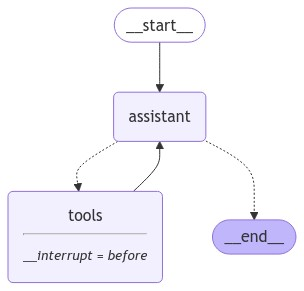

In [3]:
from IPython.display import Image, display

from langchain_core.messages.base import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")


# Node
def assistant(state: MessagesState) -> dict[str, list[BaseMessage]]:
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    source="assistant",
    # assistantからの最新のメッセージ(結果)がtool callである場合 -> tools_condition routes to tools
    # assistantからの最新のメッセージ(結果)がtool callでない場合 -> tools_condition routes to END
    path=tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [4]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# 最初の中断ポイントまで、グラフを実行する
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_u72M8bbAr2YsmjSwO2N5Kgzo)
 Call ID: call_u72M8bbAr2YsmjSwO2N5Kgzo
  Args:
    a: 2
    b: 3


状態を取得して、次に呼び出すノードを調べることができます。

これは、グラフが中断されたことを確認する良い方法です。


In [5]:
state = graph.get_state(thread)
state.next

('tools',)

さて、素敵なトリックを紹介しましょう。

`None`でグラフを起動(invoke)すると、グラフは最後の状態のチェックポイントから続行します！

![breakpoints.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbae7985b747dfed67775d_breakpoints1.png)

分かりやすくするために、LangGraphはtool callで`AIMessage`を含む現在の状態を再実行(re-emit)します。

そして、ツールノードから始まるグラフの次のステップを実行します。

このtool callでツールノードが実行され、最終的な答えのためにチャットモデルに戻されることがわかります。


In [6]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_u72M8bbAr2YsmjSwO2N5Kgzo)
 Call ID: call_u72M8bbAr2YsmjSwO2N5Kgzo
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The product of 2 and 3 is 6.


では、ユーザーの入力を受け付ける特定のユーザー承認ステップで、これらをまとめてみましょう。

In [7]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event["messages"][-1].pretty_print()

else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_shbB9G1DTqwnqNjoVae5DqZG)
 Call ID: call_shbB9G1DTqwnqNjoVae5DqZG
  Args:
    a: 2
    b: 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_shbB9G1DTqwnqNjoVae5DqZG)
 Call ID: call_shbB9G1DTqwnqNjoVae5DqZG
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


上記の結果は、 yes を入力したときの結果です。

### LangGraph APIによるブレークポイント

--

**⚠️ 注意**

*LangGraph Studioの実行には現在Macが必要です。*

*このノートブックをCoLabで実行している場合は、このステップをスキップしてください*

--

`module-3/studio/langgraph.json`に設定された`module-3/studio/agent.py`を使う `agent`をStudioのUIにロードしてみましょう。

StudioからローカルデプロイのURLを取得してみましょう。

![スクリーンショット 2024-08-26 at 9.36.41 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbae7989b1d60204c199dc_breakpoints2.png)

The LangGraph API [supports breakpoints](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_breakpoint/#sdk-initialization).





In [ ]:
from IPython import get_ipython
import platform

if "google.colab" in str(get_ipython()) or platform.system() != "Darwin":
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab or requires a Mac")

In [8]:
from langgraph_sdk import get_client

client = get_client(url="http://localhost:56091")

上記のように、LangGraph Studioで実行中のグラフをコンパイルするときに `interrupt_before=["node"]` を追加します。

しかし、APIを使用すると、ストリームメソッドに直接 `interrupt_before` を渡すこともできます。

In [9]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get("messages", [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'b26e0925-dd25-48b7-89a0-df943b84d00c', 'example': False}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_xBnIyT4A3GWdUKwYaszvsF86', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-23b42ff9-a16a-4237-9e96-b9a8885cb072', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_xBnIyT4A3GWdUKwYaszvsF86', 'type': 'tool_call'

これで、先ほどと同じように `thread_id` と `None` を入力として渡すことで、ブレークポイントから処理を進めることができます！

In [10]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=None,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get("messages", [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_xBnIyT4A3GWdUKwYaszvsF86', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-23b42ff9-a16a-4237-9e96-b9a8885cb072', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_xBnIyT4A3GWdUKwYaszvsF86', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------------------------------------
Receiving new event of type: values...
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': 'fac55b94-3ad6-471b-8cda-8d33a409760a', 'tool_call_id': 'call_xBnIyT4A3GWdUKwYas